In [5]:
!pip install climt
!pip install sympl

## Start Dask Cluster

In [1]:
import dask_kubernetes
import distributed
import socket
cluster = dask_kubernetes.KubeCluster.from_yaml('worker-template.yaml',
                                                ip=socket.gethostname())
cluster.scale(2)
client = distributed.Client(cluster)
cluster

In [3]:
import os

def setup_workers():
    os.system('pip install climt') #install what you need
    os.system('pip install sympl') 
    #os.system('pip install pyro-ppl') 
    #os.system('pip install seaborn') 

client.run(setup_workers)

{'tcp://100.96.51.230:46547': None, 'tcp://100.96.8.240:45261': None}

## Imports

In [6]:
from dask import delayed
import dask.bag as db
import climt
from sympl import (
    PlotFunctionMonitor, NetCDFMonitor,
    TimeDifferencingWrapper, UpdateFrequencyWrapper,
    set_constant
)
import numpy as np
from datetime import timedelta

In [7]:
def plot_function(fig, state):

    ax = fig.add_subplot(2, 2, 1)
    state['specific_humidity'].mean(
        dim='lon').plot.contourf(
            ax=ax, levels=16, robust=True)
    ax.set_title('Specific Humidity')

    ax = fig.add_subplot(2, 2, 3)
    state['eastward_wind'].mean(dim='lon').plot.contourf(
        ax=ax, levels=16, robust=True)
    ax.set_title('Zonal Wind')

    ax = fig.add_subplot(2, 2, 2)
    state['air_temperature_tendency_from_convection'].transpose().mean(
        dim='lon').plot.contourf(
        ax=ax, levels=16, robust=True)
    ax.set_title('Conv. Heating Rate')

    ax = fig.add_subplot(2, 2, 4)
    state['air_temperature'].mean(dim='lon').plot.contourf(
        ax=ax, levels=16)
    ax.set_title('Temperature')

    fig.tight_layout()


fields_to_store = ['air_temperature', 'air_pressure', 'eastward_wind',
                   'northward_wind', 'air_pressure_on_interface_levels',
                   'surface_pressure', 'upwelling_longwave_flux_in_air',
                   'specific_humidity', 'surface_temperature',
                   'convective_heating_rate', 'latitude', 'longitude']
# Create plotting object
monitor = PlotFunctionMonitor(plot_function)
netcdf_monitor = NetCDFMonitor('gcm_without_seasonal_cycle.nc',
                               write_on_store=True,
                               store_names=fields_to_store)

In [8]:
import sympl
sympl.get_constant('stellar_irradiance', 'W m^-2')

1367.0

In [16]:
def model(my_state=None, n_steps=0):
    set_constant('stellar_irradiance', value=200, units='W m^-2')

    model_time_step = timedelta(minutes=10)
    # Create components
    convection = climt.EmanuelConvection()
    simple_physics = TimeDifferencingWrapper(climt.SimplePhysics())

    radiation_step = timedelta(hours=1)

    radiation_lw = UpdateFrequencyWrapper(
        climt.RRTMGLongwave(), radiation_step)

    radiation_sw = UpdateFrequencyWrapper(
        climt.RRTMGShortwave(), radiation_step)

    slab_surface = climt.SlabSurface()

    dycore = climt.GFSDynamicalCore(
        [simple_physics, slab_surface, radiation_sw,
         radiation_lw, convection], number_of_damped_levels=5
    )
    grid = climt.get_grid(nx=128, ny=62)
    
    if my_state is None:
        # Create model state
        my_state = climt.get_default_state([dycore], grid_state=grid)

        # Set initial/boundary conditions
        latitudes = my_state['latitude'].values
        longitudes = my_state['longitude'].values

        zenith_angle = np.radians(latitudes)
        surface_shape = latitudes.shape

        my_state['zenith_angle'].values = zenith_angle

        my_state['eastward_wind'].values[:] = np.random.randn(
            *my_state['eastward_wind'].shape)
        my_state['ocean_mixed_layer_thickness'].values[:] = 50

        surf_temp_profile = 290 - (40*np.sin(zenith_angle)**2)
        my_state['surface_temperature'].values = surf_temp_profile

    for i in range(n_steps):
        diag, my_state = dycore(my_state, model_time_step)
        my_state.update(diag)
        my_state['time'] += model_time_step

    return my_state


In [17]:
my_state = model()

In [12]:
dask_model = delayed(model)(my_state=my_state, n_steps=24*6)

In [13]:
#dask_model.compute()

In [14]:
def monitors_diagnostics(my_state):
    netcdf_monitor.store(my_state)
    monitor.store(my_state)
    print('max. zonal wind: ', np.amax(my_state['eastward_wind'].values))
    print('max. humidity: ', np.amax(my_state['specific_humidity'].values))
    print('max. surf temp: ', np.amax(my_state['surface_temperature'].values))

    print(my_state['time'])
    

In [13]:
def dask_model(my_state, n_full=365, n_steps=144):
    for i in range(n_full):
        my_state = model(my_state=my_state, n_steps=24*6)

        monitors_diagnostics(my_state)
    return my_state

In [15]:
my_state = delayed(dask_model)(my_state, n_full=1, n_steps=1).compute()

/srv/conda/envs/notebook/lib/python3.6/site-packages/sympl/_core/tracers.py:202: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  array[tracer_slice] = raw_state[name]
/srv/conda/envs/notebook/lib/python3.6/site-packages/sympl/_core/tracers.py:229: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  raw_state[name] = tracer_array[tracer_slice]
/srv/conda/envs/notebook/lib/python3.6/site-packages/sympl/_core/tracers.py:202: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[s

IndexError: size of data array does not conform to slice

In [30]:
delayed(model)

Delayed('model-e79314ba-b03c-42d4-8660-89811e612d36')

In [ ]:
for i in range(365):
    my_state = model(my_state=my_state, n_steps=24*6)
    
    netcdf_monitor.store(my_state)
    monitor.store(my_state)
    print('max. zonal wind: ', np.amax(my_state['eastward_wind'].values))
    print('max. humidity: ', np.amax(my_state['specific_humidity'].values))
    print('max. surf temp: ', np.amax(my_state['surface_temperature'].values))

    print(my_state['time'])

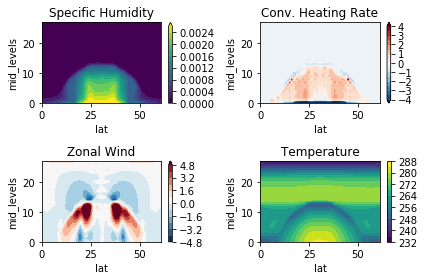

max. zonal wind:  20.483620180837814
max. humidity:  0.003957446253895268
max. surf temp:  289.8981140557802
2000-01-18 22:10:00


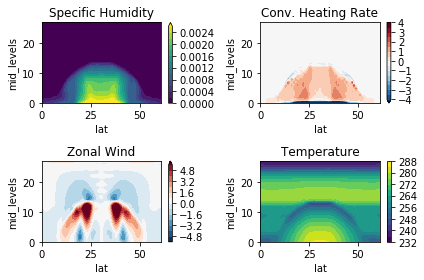

max. zonal wind:  20.1222638633102
max. humidity:  0.004035264510192174
max. surf temp:  289.8987674381444
2000-01-19 22:10:00


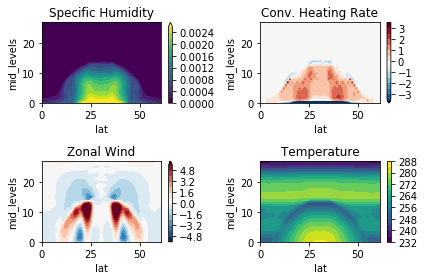

max. zonal wind:  21.39085850903902
max. humidity:  0.004089882932529935
max. surf temp:  289.90059101651974
2000-01-20 22:10:00


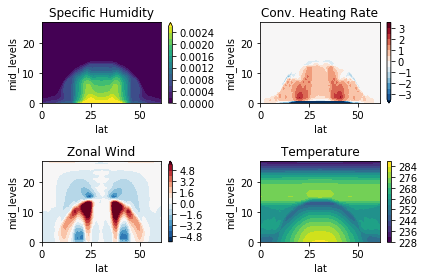

max. zonal wind:  21.870302100552088
max. humidity:  0.00408979354952206
max. surf temp:  289.9045404218653
2000-01-21 22:10:00


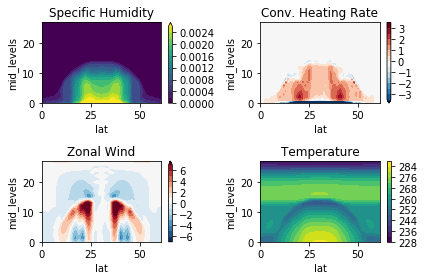

max. zonal wind:  20.95716236941943
max. humidity:  0.004153715042593794
max. surf temp:  289.90568453961293
2000-01-22 22:10:00


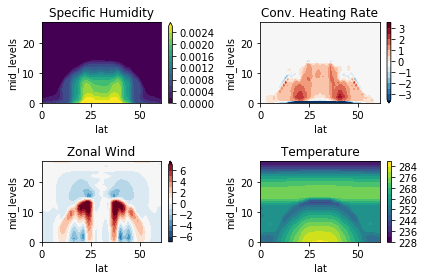

max. zonal wind:  20.234594263198122
max. humidity:  0.0044162319498333436
max. surf temp:  289.8987473827532
2000-01-23 22:10:00


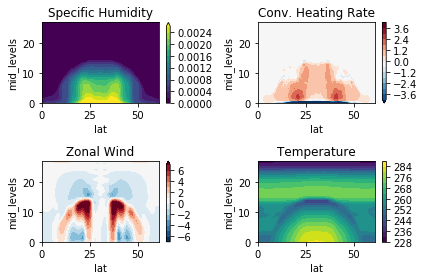

max. zonal wind:  22.339371489290027
max. humidity:  0.004918636936527144
max. surf temp:  289.8890991686992
2000-01-24 22:10:00


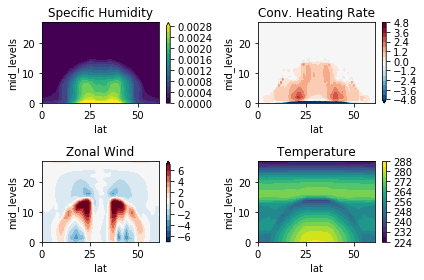

max. zonal wind:  26.306375848094625
max. humidity:  0.005268586040304119
max. surf temp:  289.88043108736395
2000-01-25 22:10:00


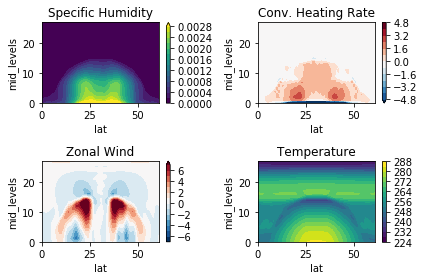

max. zonal wind:  32.21331463453303
max. humidity:  0.0052588523051979846
max. surf temp:  289.8692897140806
2000-01-26 22:10:00


In [ ]:
monitor = PlotFunctionMonitor(plot_function, False)
for i in range(365*24*6):
    diag, my_state = dycore(my_state, model_time_step)
    my_state.update(diag)
    my_state['time'] += model_time_step

    if i % (6*24) == 0:
        netcdf_monitor.store(my_state)
        monitor.store(my_state)
        print('max. zonal wind: ', np.amax(my_state['eastward_wind'].values))
        print('max. humidity: ', np.amax(my_state['specific_humidity'].values))
        print('max. surf temp: ', np.amax(my_state['surface_temperature'].values))

        print(my_state['time'])

In [8]:
import pickle
pickle.dump(my_state, open('my_state','wb'))

In [3]:
import pickle
my_state = pickle.load(open('my_state','rb'))

In [5]:
my_state['time']

datetime.datetime(2000, 1, 27, 7, 0)